In [1]:
import pandas as pd
import numpy as np
import os,io
from io import BytesIO

In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [3]:
# from azure.storage.blob import BlobServiceClient
# CONNECTION_STRING="DefaultEndpointsProtocol=https;AccountName=uksuafc010sta01;AccountKey=c63p7YkyPtTpsu6G1wcW6FYq0+zYtxKaJe0D0qqZZVP0MMgXumpGubVwBGPF3RKdWUwG9TYzrRzu+AStsaquVg==;EndpointSuffix=core.windows.net"
# blob_service_client = BlobServiceClient.from_connection_string(CONNECTION_STRING)

In [4]:
# container_name = "uk-tax-reconciliation"
# files_tb="Training data-latest.xlsx"
# blob_client = blob_service_client.get_blob_client(container=container_name, blob=files_tb)
# training_data = BytesIO(blob_client.download_blob().content_as_text(encoding=None))

In [6]:
df=pd.read_excel(r'C:\Users\SZ346RW\Downloads\Training data-latest1.xlsx',sheet_name='Training data')

In [7]:
df['SCOA Grouping'].replace('', np.nan, inplace=True)
df.dropna(subset=['SCOA Grouping'], inplace=True)

In [8]:
df['SCOA Grouping'].isnull().sum()

0

In [9]:
counts=df['SCOA Grouping'].value_counts()
counts

Administrative and Distribution Costs            451
Staffing and director costs                      414
Revenue                                          325
Building charges and maintenance                 315
Interest payable and similar charges             313
Tangible Fixed Assets                            291
Advertising, entertaining and marketing costs    281
Subsistence and transportation                   263
Accountancy, legal and professional fees         239
Legal and consultancy fees                       216
Intangible Fixed Assets                          214
Provisions                                       205
Cost of sales                                    176
Fixed and intangible asset movements             173
Repairs and capital items                        168
Receivables And Prepayments                      161
Interest and similar income                      155
Project, building and architecture fees          149
Accountancy and tax fees                      

In [10]:
df.shape

(7236, 9)

In [11]:
df.columns

Index(['IS/BS?', 'Account description', 'SCOA Grouping', 'Report Item Name',
       'Beehive Mapping Code', 'Beehive Mapping Path', 'Quantity',
       'Data source', 'Unnamed: 8'],
      dtype='object')

In [12]:
weight_list=[]
for i in counts:
    weight=1-(i/sum(counts))
    weight_list.append(weight)

In [13]:
possible_labels = df['SCOA Grouping'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Revenue': 0,
 'Administrative and Distribution Costs': 1,
 'Building charges and maintenance': 2,
 'Subsistence and transportation': 3,
 'Donations and subscriptions costs': 4,
 'Accountancy, legal and professional fees': 5,
 'Accountancy and tax fees': 6,
 'Legal and consultancy fees': 7,
 'Intercompany Receivables': 8,
 'Payables': 9,
 'Other Current Assets': 10,
 'Accruals': 11,
 'Financial Liabilities': 12,
 'Project, building and architecture fees': 13,
 'Staffing and director costs': 14,
 'Provisions': 15,
 'Advertising, entertaining and marketing costs': 16,
 'Warehouse and shipping costs': 17,
 'IT costs': 18,
 'Fixed and intangible asset movements': 19,
 'Interest payable and similar charges': 20,
 'Tangible Fixed Assets': 21,
 'Intangible Fixed Assets': 22,
 'Software': 23,
 'Repairs and capital items': 24,
 'Insurance': 25,
 'Share Capital': 26,
 'Intercompany Payables': 27,
 'Cash And Cash Equivalents': 28,
 'Receivables And Prepayments': 29,
 'Non-current Liabilities': 3

In [14]:
df['label'] = df['SCOA Grouping'].replace(label_dict)

In [15]:
df["New_Account_description"] = df['IS/BS?'].astype(str) +"-"+ df["Account description"]

In [16]:
df["New_Account_description"]

0                    Income Statement-3rd party income
1               Income Statement-3rd party loan waiver
2               Income Statement-3rd party loan waiver
3               Income Statement-3rd party loan waiver
4             Income Statement-Third party loan waiver
                             ...                      
7233               Income Statement-Workplace training
7234       Balance Sheet-Work in progress  accrued rev
7235               Income Statement-Workwear   Laundry
7236                Balance Sheet-YEAR END PROFIT LOSS
7237    Balance Sheet-Zimbabwe Pension control account
Name: New_Account_description, Length: 7236, dtype: object

In [17]:
X=df['New_Account_description']
y=df['label']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=101, test_size=0.15, 
                                                                    stratify=df['label'])

In [19]:
print(len(X_train),len(X_val),len(y_train), len(y_val))

6150 1086 6150 1086


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [21]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=100, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=100, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\SZ346RW\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [23]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.tolist())

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.tolist())

In [24]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

In [27]:
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

C:\Users\SZ346RW\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [30]:
import random

seed_val = 20
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

print(device)

cpu


In [32]:
import torch.nn as nn
weights= torch.tensor(weight_list,dtype=torch.float)
weights = weights.to(device)

# loss function
# cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)
print(cross_entropy)

CrossEntropyLoss()


In [33]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        # loss = outputs[0]
        
        loss = cross_entropy(outputs[1],inputs['labels'])

        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        # outputs = model(**inputs)
        outputs = model(**inputs)
        loss = cross_entropy(outputs[1],inputs['labels'])
        # loss = outputs[0]
        
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'../final-models/BERT-Model_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [34]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict), output_attentions=False,output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [35]:
model.load_state_dict(torch.load(r'./last trained/New-BERT-Model_10.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [43]:
from sklearn.metrics import classification_report

In [44]:
y_val

6653    14
1044    17
7078     9
5933    15
484     14
        ..
4347     3
1172     1
3746    17
4940    36
2974    18
Name: label, Length: 1086, dtype: int64

In [45]:
predictions

array([[ 0.3982449 ,  1.0818213 ,  1.2451818 , ..., -0.51693803,
        -1.6764075 , -1.6054032 ],
       [ 0.48567173,  4.850326  ,  0.9610041 , ..., -0.69776756,
        -1.8302963 , -1.6998669 ],
       [-2.4304264 , -0.39047557, -0.673473  , ..., -0.19483212,
        -0.13390018,  1.1749882 ],
       ...,
       [-0.46871826,  0.9084194 ,  0.84923285, ..., -0.18685888,
        -1.7610945 , -1.2894924 ],
       [ 1.2719065 ,  0.7629484 , -1.1311922 , ..., -0.29534397,
        -1.1943018 , -0.57235885],
       [-1.022112  ,  1.3661698 , -0.16283117, ..., -0.9727642 ,
         0.8321421 , -1.0825726 ]], dtype=float32)

In [46]:
preds = np.argmax(predictions, axis = 1).flatten()

In [47]:
preds

array([14, 14,  9, ..., 17, 36, 18], dtype=int64)

In [48]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        49
           1       0.96      0.96      0.96        68
           2       0.98      0.89      0.93        47
           3       0.95      0.93      0.94        40
           4       1.00      1.00      1.00        17
           5       0.88      0.83      0.86        36
           6       0.83      0.95      0.89        21
           7       0.89      1.00      0.94        32
           8       1.00      1.00      1.00         6
           9       0.67      0.89      0.76        18
          10       1.00      1.00      1.00        10
          11       1.00      0.93      0.97        15
          12       0.90      0.95      0.93        20
          13       0.92      1.00      0.96        22
          14       0.92      0.95      0.94        62
          15       0.97      0.97      0.97        31
          16       0.98      0.95      0.96        42
          17       0.94    

C:\Users\SZ346RW\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SZ346RW\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SZ346RW\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
cm = confusion_matrix(y_val, preds)

In [52]:
cm

array([[47,  1,  0, ...,  0,  0,  0],
       [ 0, 65,  0, ...,  0,  0,  0],
       [ 0,  0, 42, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0,  4,  0],
       [ 0,  0,  0, ...,  0,  0,  4]], dtype=int64)

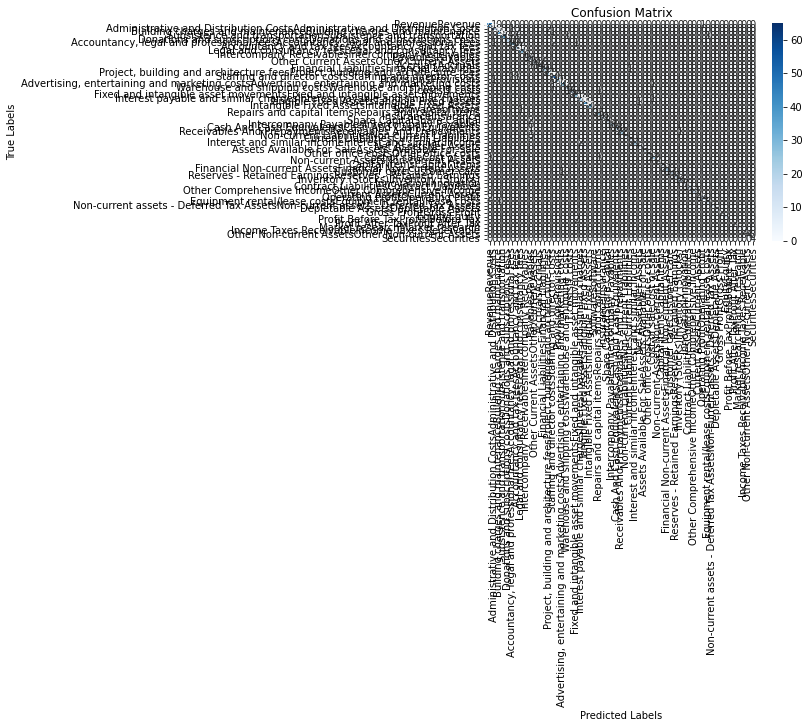

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a confusion matrix


# Define class labels
class_names = ['RevenueRevenue',
'Administrative and Distribution CostsAdministrative and Distribution Costs',
'Building charges and maintenanceBuilding charges and maintenance',
'Subsistence and transportationSubsistence and transportation',
'Donations and subscriptions costsDonations and subscriptions costs',
'Accountancy, legal and professional feesAccountancy, legal and professional fees',
'Accountancy and tax feesAccountancy and tax fees',
'Legal and consultancy feesLegal and consultancy fees',
'Intercompany ReceivablesIntercompany Receivables',
'PayablesPayables',
'Other Current AssetsOther Current Assets',
'AccrualsAccruals',
'Financial LiabilitiesFinancial Liabilities',
'Project, building and architecture feesProject, building and architecture fees',
'Staffing and director costsStaffing and director costs',
'ProvisionsProvisions',
'Advertising, entertaining and marketing costsAdvertising, entertaining and marketing costs',
'Warehouse and shipping costsWarehouse and shipping costs',
'IT costsIT costs',
'Fixed and intangible asset movementsFixed and intangible asset movements',
'Interest payable and similar chargesInterest payable and similar charges',
'Tangible Fixed AssetsTangible Fixed Assets',
'Intangible Fixed AssetsIntangible Fixed Assets',
'SoftwareSoftware',
'Repairs and capital itemsRepairs and capital items',
'InsuranceInsurance',
'Share CapitalShare Capital',
'Intercompany PayablesIntercompany Payables',
'Cash And Cash EquivalentsCash And Cash Equivalents',
'Receivables And PrepaymentsReceivables And Prepayments',
'Non-current LiabilitiesNon-current Liabilities',
'Current LiabilitiesCurrent Liabilities',
'Interest and similar incomeInterest and similar income',
'Net AssetsNet Assets',
'Assets Available For SaleAssets Available For Sale',
'Other office costsOther office costs',
'Cost of saleCost of sale',
'Non-current AssetsNon-current Assets',
'Capital itemsCapital items',
'Financial Non-current AssetsFinancial Non-current Assets',
'Customer careCustomer care',
'Reserves - Retained EarningsReserves - Retained Earnings',
'Inventory (Stocks)Inventory (Stocks)',
'InnovationInnovation',
'Contract LiabilitiesContract Liabilities',
'Other Comprehensive IncomeOther Comprehensive Income',
'Current AssetsCurrent Assets',
'Operating ProfitOperating Profit',
'Equipment rental/lease costsEquipment rental/lease costs',
'Non-current assets - Deferred Tax AssetsNon-current assets - Deferred Tax Assets',
'Depletable AssetsDepletable Assets',
'Gross ProfitGross Profit',
'EquityEquity',
'Profit Before TaxProfit Before Tax',
'Profit After TaxProfit After Tax',
'Market researchMarket research',
'Income Taxes ReceivableIncome Taxes Receivable',
'Other Non-current AssetsOther Non-current Assets',
'SecuritiesSecurities',
]

# Create a heatmap plot of the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_names)
# plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_names)

# Show the plot
plt.show()


In [38]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    data=dict(class_name=[],predicted=[],Total_count=[])

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        data['class_name'].append(label_dict_inverse[label])
        data['predicted'].append(len(y_preds[y_preds==label]))
        data['Total_count'].append(len(y_true))
        
    return data

In [39]:
data=accuracy_per_class(predictions, true_vals)

Class: Revenue
Accuracy: 47/49

Class: Administrative and Distribution Costs
Accuracy: 65/68

Class: Building charges and maintenance
Accuracy: 42/47

Class: Subsistence and transportation
Accuracy: 37/40

Class: Donations and subscriptions costs
Accuracy: 17/17

Class: Accountancy, legal and professional fees
Accuracy: 30/36

Class: Accountancy and tax fees
Accuracy: 20/21

Class: Legal and consultancy fees
Accuracy: 32/32

Class: Intercompany Receivables
Accuracy: 6/6

Class: Payables
Accuracy: 16/18

Class: Other Current Assets
Accuracy: 10/10

Class: Accruals
Accuracy: 14/15

Class: Financial Liabilities
Accuracy: 19/20

Class: Project, building and architecture fees
Accuracy: 22/22

Class: Staffing and director costs
Accuracy: 59/62

Class: Provisions
Accuracy: 30/31

Class: Advertising, entertaining and marketing costs
Accuracy: 40/42

Class: Warehouse and shipping costs
Accuracy: 16/17

Class: IT costs
Accuracy: 16/17

Class: Fixed and intangible asset movements
Accuracy: 25/26


In [40]:
my_df=pd.DataFrame()
my_df[0]= data['class_name']
my_df[1]= data['predicted']
my_df[2]= data['Total_count']
my_df=my_df.rename(columns={0:'Grouping_name',1:'predicted_count',2:'total_count'})
my_df

,Grouping_name,predicted_count,total_count
0,Revenue,47,49
1,Administrative and Distribution Costs,65,68
2,Building charges and maintenance,42,47
3,Subsistence and transportation,37,40
4,Donations and subscriptions costs,17,17
5,"Accountancy, legal and professional fees",30,36
6,Accountancy and tax fees,20,21
7,Legal and consultancy fees,32,32
8,Intercompany Receivables,6,6
9,Payables,16,18


<Figure size 2160x1008 with 0 Axes>

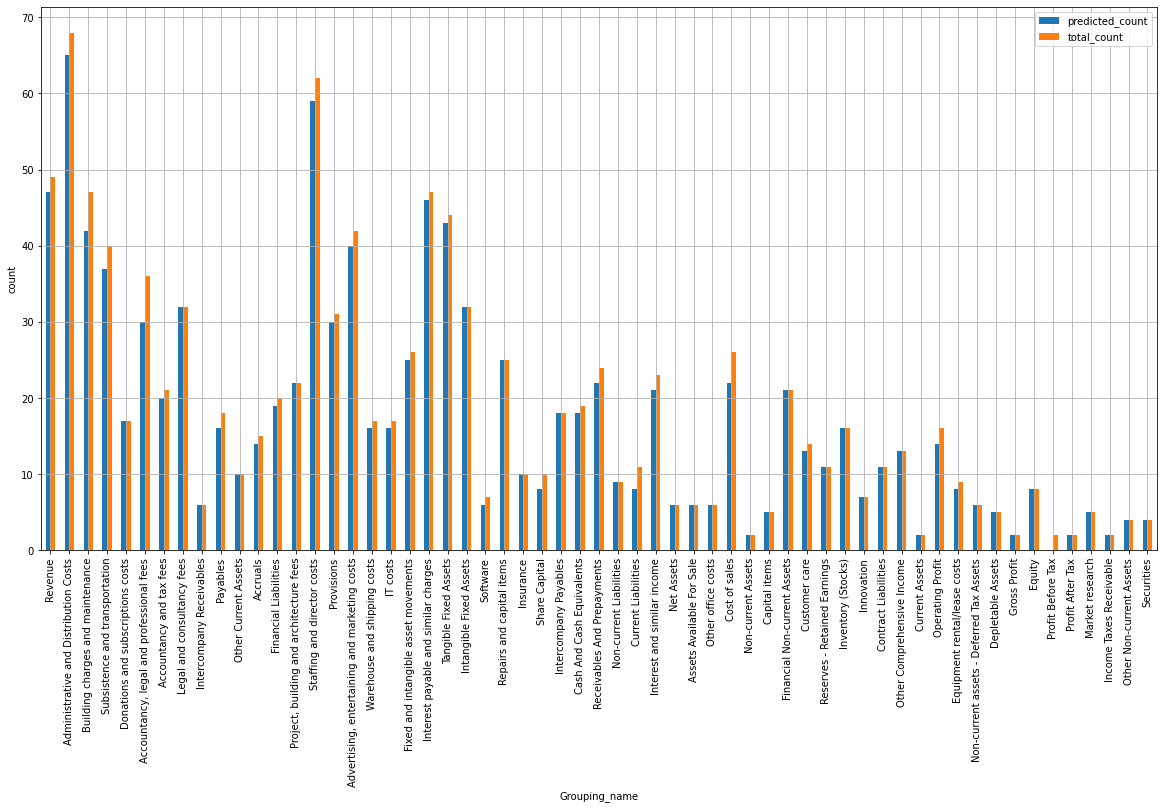

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 14))
# plot the dataframe
my_df.plot(x="Grouping_name", y=["predicted_count", "total_count"], kind="bar", figsize=(20, 10))
plt.rc('axes', titlesize=70)
plt.ylabel("count")

plt.rc('xtick', labelsize=10)

plt.grid()



# print bar graph
plt.show()

In [14]:
test_df=pd.read_csv(r'C:\Users\SZ346RW\Downloads\fstb_coa\files\data\Alliance_Flooring_Distribution_Limited-Year_ended_31_March_2022-Chart_Of_Accounts-20221011T093244Z.csv')

In [15]:
test_df.head()

,Report Name,Account Code,Account Description,Trial Balance,Beehive Mapping Code,Beehive Mapping Path,Beehive Report Item Name
0,Balance Sheet,100000,BALANCE SHEET,0.00,NaN,NaN,NaN
1,Balance Sheet,110000,ASSETS,0.00,NaN,NaN,NaN
2,Balance Sheet,110005,Fixed Assets,0.00,NaN,NaN,NaN
3,Balance Sheet,110010,AUCC,246116.37,NaN,NaN,NaN
4,Balance Sheet,111000,Tangible Fixed Assets,0.00,NaN,NaN,NaN


In [16]:
isbs_df=test_df.copy()

In [17]:
isbs_df.columns

Index(['Report Name', 'Account Code', 'Account Description', 'Trial Balance',
       'Beehive Mapping Code', 'Beehive Mapping Path',
       'Beehive Report Item Name'],
      dtype='object')

In [18]:
isbs_df['Account Description'] = isbs_df['Account Description'].replace(to_replace=r'[^a-zA-Z0-9\s]',value =' ',regex = True).replace(r'[0-9]',value ='',regex=True)

In [20]:
isbs_df['Account Description'] =isbs_df['Account Description'].replace({pd.NA: 1})

In [21]:
isbs_df['Account Description'] = isbs_df['Account Description'].replace(1,'na')#.str.replace('\d+', 'na')
isbs_df['Account Description'] = isbs_df['Account Description'].str.strip()
isbs_df['Account Description']

0                 BALANCE SHEET
1                        ASSETS
2                  Fixed Assets
3                          AUCC
4         Tangible Fixed Assets
                 ...           
404           Dividends Payable
405             Total Dividends
406    Total Operating Expenses
407                  Total Cost
408     Opening Balance Account
Name: Account Description, Length: 409, dtype: object

In [22]:
isbs_df["new_Account Description"] = isbs_df['Report Name'].astype(str) +"-"+ isbs_df['Account Description']

In [23]:
isbs_df.head()

,Report Name,Account Code,Account Description,Trial Balance,Beehive Mapping Code,Beehive Mapping Path,Beehive Report Item Name,new_Account Description
0,Balance Sheet,100000,BALANCE SHEET,0.00,NaN,NaN,NaN,Balance Sheet-BALANCE SHEET
1,Balance Sheet,110000,ASSETS,0.00,NaN,NaN,NaN,Balance Sheet-ASSETS
2,Balance Sheet,110005,Fixed Assets,0.00,NaN,NaN,NaN,Balance Sheet-Fixed Assets
3,Balance Sheet,110010,AUCC,246116.37,NaN,NaN,NaN,Balance Sheet-AUCC
4,Balance Sheet,111000,Tangible Fixed Assets,0.00,NaN,NaN,NaN,Balance Sheet-Tangible Fixed Assets


In [24]:
test_text=isbs_df['new_Account Description']

In [27]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_text.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=100, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\SZ346RW\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict), output_attentions=False,output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [41]:
model.load_state_dict(torch.load(r'./last trained/New-BERT-Model_10.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
# preds = model(input_ids_test, attention_masks_test)
with torch.no_grad():
    preds = model(input_ids_test.to(device), attention_masks_test.to(device))

In [43]:
preds

SequenceClassifierOutput(loss=None, logits=tensor([[-3.5087, -2.0830, -1.0446,  ..., -0.3544,  0.9704,  1.5323],
        [-0.3656, -2.1690, -0.4996,  ...,  0.9647,  0.3066,  0.6460],
        [-2.3637, -0.6601,  0.5218,  ..., -0.7707, -0.4129,  1.0931],
        ...,
        [ 3.2168,  0.7250, -0.0681,  ..., -0.7321, -1.0220, -0.4702],
        [ 0.3662, 10.3306, -0.3440,  ..., -0.7825, -0.6555, -0.2975],
        [-0.5191, -3.6615,  0.0374,  ..., -0.0626,  1.0275, -0.4221]]), hidden_states=None, attentions=None)

In [44]:
logits=preds[0]

In [45]:
prediction_list=[]
prediction_list.append(logits)
prediction = np.concatenate(prediction_list, axis=0)

In [47]:
final_prediction = np.argmax(prediction, axis = 1).flatten()

In [48]:
df4=pd.DataFrame()
df4=df4.append(test_df)
df4['Prediction_label']=final_prediction

<ipython-input-48-9f0664c2c813>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df4=df4.append(test_df)


In [49]:
df4

,Report Name,Account Code,Account Description,Trial Balance,Beehive Mapping Code,Beehive Mapping Path,Beehive Report Item Name,Prediction_label
0,Balance Sheet,100000,BALANCE SHEET,0.00,NaN,NaN,NaN,42
1,Balance Sheet,110000,ASSETS,0.00,NaN,NaN,NaN,33
2,Balance Sheet,110005,Fixed Assets,0.00,NaN,NaN,NaN,21
3,Balance Sheet,110010,AUCC,246116.37,NaN,NaN,NaN,37
4,Balance Sheet,111000,Tangible Fixed Assets,0.00,NaN,NaN,NaN,21
...,...,...,...,...,...,...,...,...
404,Income Statement,270005,Dividends Payable,0.00,72000000.0,/incomeStatement/profitAfterTax/dividendsPayable,Dividends payable,47
405,Income Statement,279999,Total Dividends,0.00,NaN,NaN,NaN,47
406,Income Statement,298999,Total Operating Expenses,3810809.81,NaN,NaN,NaN,47
407,Income Statement,299999,Total Cost,648567.22,NaN,NaN,NaN,1


In [50]:
inv_map = {v: k for k, v in label_dict.items()}

In [51]:
df4['Predicted group']=df4['Prediction_label'].replace(inv_map)

In [52]:
df4.to_excel('Alliance_Flooring_Distribution-model-output.xlsx')